# Learning with a Wasserstein Loss

#### Master Stat ML

François-Pierre Paty & Raphaël Huille



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris

%matplotlib inline

I will implement algorithm presented in : https://arxiv.org/pdf/1506.05439.pdf

# Implementation

In [2]:
class predictor:
    
    def __init__(self, loss ='wasserstein', method = 'gradient', n_iter = 10,
                 batch_size = 10, eta = 0.01, ground_metric = None, lambda_ = 0.1):
        
        self.loss = loss
        self.method = method
        self.eta = eta
        self.s = batch_size
        self.n_iter = n_iter
        self.l = lambda_
        self.M = ground_metric # have a default value
        #
        
        # data
        self.X = None
        self.y = None
        self.t = None
        
        # size
        self.m = None
        self.n = None
        self.p = None
        
        # storage
        self.t_list = None
        self.grad_list = None

    def __str__(self):
        sb = []
        
        for key in self.__dict__:
            if key in ['X', 'y', 't', 'M', 't_list', 'grad_list']:
                continue
            sb.append("{key}='{value}'".format(key=key, value=self.__dict__[key]))
                               
        return 'predictor (' + ', '.join(sb) + ')'
    
    def __repr__(self):
        return self.__str__()
    
    def train(self, X, y, theta_0 = None):
        """ main interface methode """
        
        # data
        self.X = X
        self.y = y
        self.t = theta_0 # have a default value
        
        # size
        self.m = y.shape[1]
        self.n = X.shape[0]
        self.p = X.shape[1]
        
        # storage
        self.t_list = np.array([])
        self.grad_list = np.array([])
        
        # default parameters
        if self.M == None :
            self.M = np.full((self.m, self.m), 1) - np.eye(self.m)
        if self.t ==None:
            self.t = np.full((self.p, self.m), 0)
        self.t_list = [ self.t ]
        self.grad_list = []
        
        # train loss :
        if self.loss == 'wasserstein':
            self.train_wasserstein()
            
        if self.loss == 'logistic':
            self.train_logistic()
        
        return self
    
    def Sinkorn_computation(self, y_pred, y):
        """ tool """
        
        m = self.m
        l = self.l
        M = self.M
        
        K = np.exp( -l*M - 1)
        u = np.full(m, 1)
        for i in range(100):
            u = y/np.dot(u, K.T)
            u = y_pred/np.dot(u, K)

        return np.log(u)/l - np.log(u.sum())/(l*m)*np.full(m ,1)
    
    def H_gradient_computation(self, y_pred, x_i):
        """ tool """
        
        m = self.m
        p = self.p
        
        a = np.repeat(np.reshape(y_pred, newshape=(m,1)), repeats=m, axis=1)
        a = a*(np.eye(m,m) - a.T)
        a = np.reshape(a, newshape=(m,1,m))
        x_i = np.reshape(x_i, newshape=(p,1))
        a = np.dot(x_i,a)

        return a
    
    def batch_list_creator(self, s):
        """ tool """
        s = self.s
        n = self.n
        
        index = np.arange(n)
        np.random.shuffle(index)
        i_ = 0
        batch_list =[]
        for i in np.arange(s,n+s,s):
            batch_list+=[index[i_:i]]
            i_ = i
        return batch_list
    
    
    def train_wasserstein(self) :
        """ main algo of the notebook """
        m = self.m
        n = self.n
        p = self.p
        s = self.s
        eta = self.eta
        
        for xx in range(self.n_iter) :
            if self.method == 'sgd' : 
                batch_list = self.batch_list_creator(s) #calling tool
            elif self.method == 'gradient' : 
                batch_list = [np.arange(n)]
            else:
                print('self.method is not valid')
                break
                
            for batch in batch_list :
                # - compute gradient in bacth - #
                gradient = 0
                for i in batch :
                    x_i = self.X[i,:]
                    y_i = self.y[i]
                    y_pred = softmax(np.dot(x_i, self.t))

                    wasserstein_subgrad = self.Sinkorn_computation(y_pred, y_i) #calling tool
                    h_gradient = self.H_gradient_computation(y_pred, x_i) #calling tool
                    
                    gradient += np.dot(h_gradient, wasserstein_subgrad)
                # - end gradient in bacth - #
                
                # new step
                self.t = self.t - eta*gradient
                
                # storage : 
                self.t_list += [self.t]
                self.grad_list += [gradient]
        
        self.t_list = np.array(self.t_list)
        self.grad_list = np.array(self.grad_list)
        return self.t
    
    def train_logistic(self) :
        # empty
        return None
    
    def predict(self, X):
        """ main interface methode """
        
        return softmax_(np.dot(X, self.t))

# Simulation study

In [3]:
def softmax(z):
    e = np.exp(z)
    return e/e.sum() 

def softmax_(z):
    return np.apply_along_axis(softmax, 1, z)

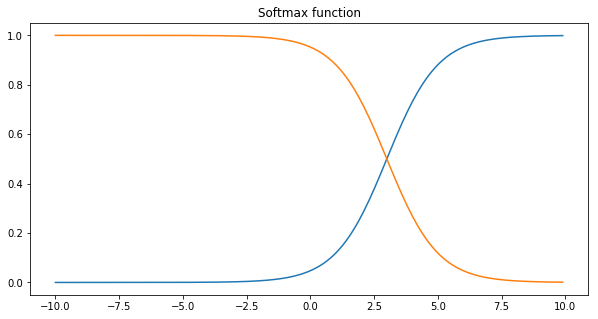

In [4]:
x = np.array([[i,3] for i in np.arange(-10,10,0.1)])
r  = np.array([softmax(k) for k in x])

plt.figure(figsize=(10,5))
plt.title('Softmax function')
plt.plot(x[:,0], r[:, 0], x[:,0], r[:, 1])
plt.show()  

### dataset

In [5]:
# parameters
n = 100 # number of observations
m = 3 # number of class
p = 5 # dimension of parameters

In [6]:
# dataset
X = np.random.uniform(-1,1,size=(n,p))
t = np.floor(np.random.uniform(-1,1,size=(p,m))*10)+1

y_latent = softmax_(np.dot(X,t)) # the 'distribution' over class
y = y_latent.argmax(axis =1) # the class

### Analysis of convergence

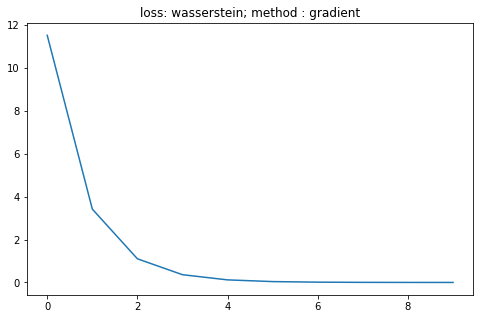

In [7]:
clf = predictor(method='gradient')
clf.train(X,y_latent)

norm_list = [np.linalg.norm(g) for g in clf.grad_list]

plt.figure(figsize=(8,5))
plt.title( 'loss: ' + clf.loss  + '; method : '+ clf.method)
plt.plot(norm_list)
plt.show()

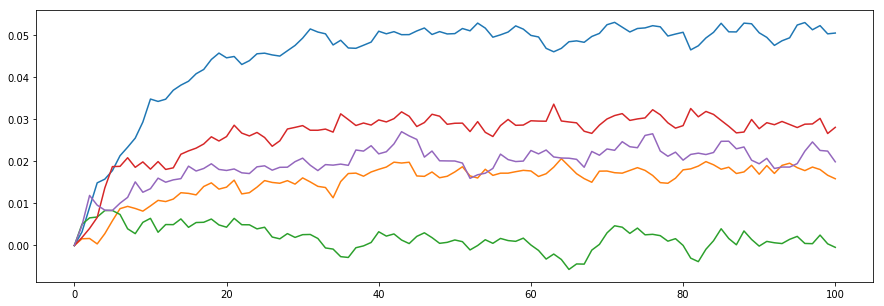

In [16]:
plt.figure(figsize=(15,5))
plt.plot(clf.t_list[:,:,0])
plt.show()

In [13]:
t

array([[  9.,  -2.,  -9.],
       [  3.,  -3.,  -2.],
       [  7.,  10.,   5.],
       [  9.,   2.,  -4.],
       [ 10.,   3.,   3.]])

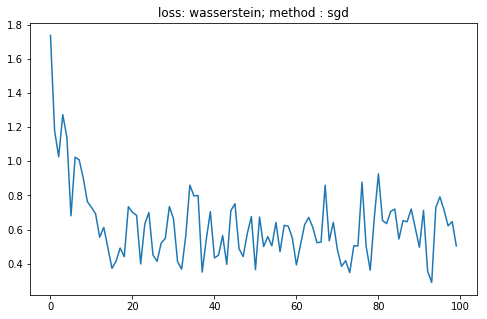

In [8]:
clf = predictor(method='sgd')
clf.train(X,y_latent)

norm_list = [np.linalg.norm(g) for g in clf.grad_list]

plt.figure(figsize=(8,5))
plt.title( 'loss: ' + clf.loss  + '; method : '+ clf.method)
plt.plot(norm_list)
plt.show()

### Analysis of prediction

In [9]:
y_latent_pred = clf.predict(X)
y_pred = y_latent_pred.argmax(axis = 1)
confusion_matrix(y_pred, y)

array([[33,  1,  0],
       [ 3, 13,  3],
       [ 3,  0, 44]])

# On iris dataset

### dataset

In [192]:
def create_latent(y):
    y_latent = np.array([ [0]*3 for i in y])
    for v,i in enumerate(y) :
        y_latent[v,i]+=1
    return y_latent

In [193]:
X = load_iris().data
y = load_iris().target
y_latent = create_latent(y)

### Analysis of convergence

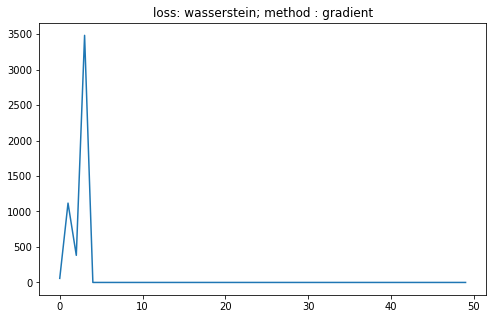

In [199]:
clf = predictor(method='gradient', eta = 0.001,n_iter=50)
clf.train(X,y_latent)

norm_list = [np.linalg.norm(g) for g in clf.grad_list]

plt.figure(figsize=(8,5))
plt.title( 'loss: ' + clf.loss  + '; method : '+ clf.method)
plt.plot(norm_list)
plt.show()

### Analysis of prediction

In [200]:
y_latent_pred = clf.predict(X)
y_pred = y_latent_pred.argmax(axis = 1)
confusion_matrix(y_pred, y)

array([[ 0,  0,  0],
       [50, 50, 50],
       [ 0,  0,  0]])

In [197]:
y_latent_pred

array([[  9.62998606e-039,   1.00000000e+000,   5.79891398e-128],
       [  1.06370316e-036,   1.00000000e+000,   1.76429573e-120],
       [  9.12545561e-036,   1.00000000e+000,   6.43179155e-118],
       [  7.44915356e-036,   1.00000000e+000,   1.68969705e-117],
       [  1.79247547e-038,   1.00000000e+000,   3.40567102e-127],
       [  1.65600718e-042,   1.00000000e+000,   6.24702990e-140],
       [  3.06485326e-036,   1.00000000e+000,   2.41022246e-119],
       [  1.94651165e-038,   1.00000000e+000,   1.61017127e-126],
       [  4.62068705e-034,   1.00000000e+000,   1.53817317e-111],
       [  3.57562668e-037,   1.00000000e+000,   4.95321630e-122],
       [  5.08635988e-041,   1.00000000e+000,   1.53438839e-135],
       [  7.32345333e-038,   1.00000000e+000,   2.62575082e-124],
       [  4.43140530e-036,   1.00000000e+000,   1.53641928e-118],
       [  1.78226849e-032,   1.00000000e+000,   2.23733085e-107],
       [  2.01787424e-042,   1.00000000e+000,   1.72641062e-141],
       [  

In [198]:
y_latent

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,